<a href="https://colab.research.google.com/github/brettmlabo/embedded_skills_series_1/blob/master/IntroToDeepLearningProject.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Intro To Deep Learning Project


In [ ]:
!pip install validators matplotlib
!pip install torchmetrics

In [ ]:
from torch.utils.data import Dataset
from google.colab import drive
from PIL import Image
from torchvision import transforms
import os

class FoodImageClassificationDataset(Dataset):
  def __init__(self, path):
    super().__init__()
    classes = os.listdir(path)
    self.data = []

    #Loads in all of the classes
    self.class_to_index = {}
    self.index_to_class = {}
    for i in range(len(classes)):
      self.class_to_index[classes[i]] = i
      self.index_to_class[i] = classes[i]
    print(self.class_to_index)

    #For each class, load in the images
    for class_name in classes:
      class_data = os.listdir(os.path.join(path, class_name))
      class_data = [os.path.join(path, class_name, img_name) for img_name in class_data]
      class_data = [(filepath, self.class_to_index[class_name]) for filepath in class_data]
      self.data += class_data

    #Initialize transform
    self.transform_to_tensor = transforms.ToTensor()
    self.transform_resize = transforms.CenterCrop((224, 224))
    self.transform_to_image = transforms.ToPILImage()

  def __getitem__(self, index):
     filepath, label = self.data[index] #Get the filepath and label
     img = Image.open(filepath)
     features = self.transform_to_tensor(img)
     features = self.transform_resize(features)
     return (features, label)

  def __len__(self):
    return len(self.data)

def load_dataset(self, path : str):
  '''Prepares the images in a folder such that they're in easily accessible key, value pairs'''

drive.mount('/content/drive')
train_dataset = FoodImageClassificationDataset("/content/drive/My Drive/state_dataset/train")
valid_dataset = FoodImageClassificationDataset("/content/drive/My Drive/state_dataset/valid")
print(f'Train: {len(train_dataset)}, Valid: {len(valid_dataset)}, Total: {len(train_dataset) + len(valid_dataset)}')
img = train_dataset[264]
print(img[0].shape)


Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).
{'juiced': 0, 'other': 1, 'floured': 2, 'creamy_paste': 3, 'diced': 4, 'grated': 5, 'jullienne': 6, 'sliced': 7, 'peeled': 8, 'whole': 9, 'mixed': 10}
{'floured': 0, 'jullienne': 1, 'mixed': 2, 'grated': 3, 'diced': 4, 'whole': 5, 'creamy_paste': 6, 'juiced': 7, 'other': 8, 'peeled': 9, 'sliced': 10}
Train: 8583, Valid: 1912, Total: 10495
torch.Size([3, 224, 224])


In [ ]:
import torch
from torch import optim, nn
import random, time
from torch.utils.data import DataLoader

data_dir = 'data/hymenoptera_data' #Modify this path according to user's drive

class FoodImageClassifier(torch.nn.Module):
  def __init__(self):
    super().__init__()
    self.resnet50 = torch.hub.load('NVIDIA/DeepLearningExamples:torchhub', 'nvidia_resnet50', pretrained = True).to(device)

    #for param in self.resnet50.parameters():
      #param.requires_grad = False

    self.resnet50.fc = nn.Sequential(
               nn.Linear(2048, 128),
               nn.ReLU(inplace=True),
               nn.Linear(128, 11)).to(device)

  def forward(self, x):
    return torch.nn.functional.sigmoid(self.resnet50(x))

device = torch.device("cuda") if torch.cuda.is_available() else torch.device("cpu")
print(f'Using {device} for inference')

def train(model, dataloader, epochs = 10):
  model.train()
  optimizer = optim.SGD(model.parameters(), lr = 1e-2, momentum=0.9)

  for epoch in range(epochs):
    for batch in dataloader:
      features, labels = batch
      features = features.to(device)
      labels = labels.to(device)
      predictions = model(features) #Get the predictions
      #labels = labels.unsqueeze(1) #Modify the output so it's the correct size
      labels = labels.long() #ensure the labels are floats
      predictions = model(features) #Find the predictions
      loss = nn.functional.cross_entropy(predictions, labels) #Compute loss

      #Update weights
      loss.backward()
      optimizer.step()
      optimizer.zero_grad()
      print(f'Loss: {loss.item()}')
    print(f'Epoch: {epoch}, Loss: {loss}')
    torch.save(classifier.state_dict(), 'trained_model.pth') # Changed 'model' to 'classifier'
    print("Model weights saved to 'trained_model.pth'")

def test(model, dataset, count):
    model.eval()
    total_correct = 0
    for i in range(count):
      with torch.no_grad():
        index = random.randint(0, len(dataset))
        input = dataset[index][0].unsqueeze(0)
        outputs = model(input)
        predictions = outputs.argmax(dim=1)
        display(dataset.transform_to_image(dataset[index][0]))
        print(f'Prediction: {dataset.index_to_class[(int)(predictions.item())]}, Label: {dataset.index_to_class[dataset[index][1]]}')
        total_correct += (sum(predictions == dataset[index][1])).item()
    print(f"Accuracy: {round(100 * total_correct / count, 2)} %")

def accuracy(model, dataset, dataloader):
    model.eval()
    size = len(dataset)
    total_correct = 0
    for batch in dataloader:
        features, labels = batch
        features = features.to(device)
        labels = labels.to(device)
        outputs = model(features)
        predictions = outputs.argmax(dim=1)
        total_correct += (sum(predictions == labels)).item()
        print(f'Correct this iter: {sum(predictions == labels).item()}, Running total: {total_correct}')
    print(f"Accuracy: {round(100 * total_correct / size, 2)} %")

Using cuda for inference


# Training Scripts

In [ ]:
#Train Script

classifier = FoodImageClassifier()
train_loader = DataLoader(train_dataset, batch_size=32, shuffle=True)
valid_loader = DataLoader(valid_dataset, batch_size=32, shuffle=True)
accuracy(classifier, valid_dataset, valid_loader) #accuracy before training
train(classifier, train_loader)
accuracy(classifier, valid_dataset, valid_loader) #accuracy after training

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


Correct this iter: 3, Running total: 3
Correct this iter: 3, Running total: 6
Correct this iter: 1, Running total: 7
Correct this iter: 3, Running total: 10
Correct this iter: 8, Running total: 18
Correct this iter: 5, Running total: 23
Correct this iter: 5, Running total: 28
Correct this iter: 6, Running total: 34
Correct this iter: 3, Running total: 37
Correct this iter: 3, Running total: 40
Correct this iter: 2, Running total: 42
Correct this iter: 3, Running total: 45
Correct this iter: 3, Running total: 48
Correct this iter: 4, Running total: 52
Correct this iter: 1, Running total: 53
Correct this iter: 4, Running total: 57
Correct this iter: 5, Running total: 62
Correct this iter: 5, Running total: 67
Correct this iter: 3, Running total: 70
Correct this iter: 6, Running total: 76
Correct this iter: 5, Running total: 81
Correct this iter: 3, Running total: 84
Correct this iter: 3, Running total: 87
Correct this iter: 2, Running total: 89
Correct this iter: 4, Running total: 93
Cor

In [ ]:
torch.save(classifier.state_dict(), 'trained_model.pth') # Changed 'model' to 'classifier'
print("Model weights saved to 'trained_model.pth'")



Model weights saved to 'trained_model.pth'


In [ ]:
# load saved weights
classifier.load_state_dict(torch.load('trained_model.pth')) #Changed 'model' to 'classifier'
classifier.eval()  # Set the model to evaluation mode

<ipython-input-8-b29e6f2ce919>:2: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  classifier.load_state_dict(torch.load('trained_model.pth')) #Changed 'model' to 'classifier'


FoodImageClassifier(
  (resnet50): ResNet(
    (conv1): Conv2d(3, 64, kernel_size=(7, 7), stride=(2, 2), padding=(3, 3), bias=False)
    (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
    (relu): ReLU(inplace=True)
    (maxpool): MaxPool2d(kernel_size=3, stride=2, padding=1, dilation=1, ceil_mode=False)
    (layers): Sequential(
      (0): Sequential(
        (0): Bottleneck(
          (conv1): Conv2d(64, 64, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn1): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv2): Conv2d(64, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1), bias=False)
          (bn2): BatchNorm2d(64, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (conv3): Conv2d(64, 256, kernel_size=(1, 1), stride=(1, 1), bias=False)
          (bn3): BatchNorm2d(256, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
          (relu): ReLU(inplac

# Testing Scripts

Using cache found in /root/.cache/torch/hub/NVIDIA_DeepLearningExamples_torchhub


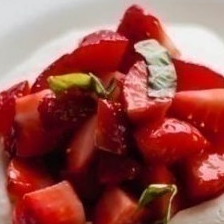

Prediction: grated, Label: diced


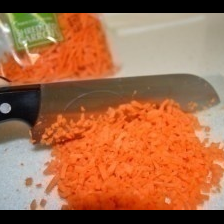

Prediction: grated, Label: grated


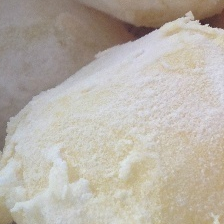

Prediction: mixed, Label: floured


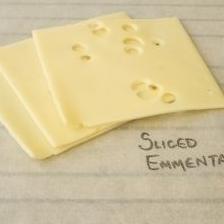

Prediction: jullienne, Label: sliced


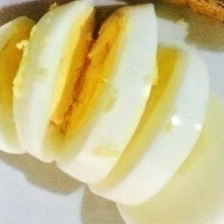

Prediction: other, Label: sliced


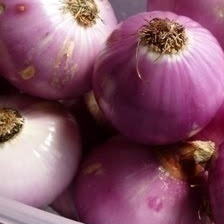

Prediction: mixed, Label: peeled


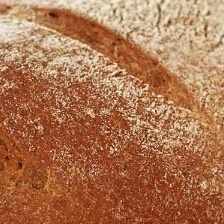

Prediction: mixed, Label: floured


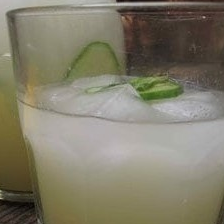

Prediction: grated, Label: juiced


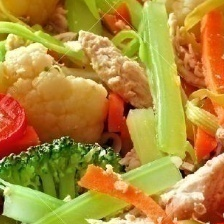

Prediction: jullienne, Label: mixed


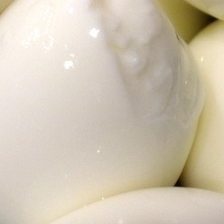

Prediction: mixed, Label: peeled
Accuracy: 10.0 %


In [ ]:
test(FoodImageClassifier(), train_dataset, 10)

In [ ]:
# Test Script- IGNORE - IT DOES NOT WORK
# Define a transformation for the test data
transform = transforms.Compose([
    transforms.Resize(256),
    transforms.CenterCrop(224),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]),
])
# Load your test dataset
# Use the path where your test dataset is stored.
test_dataset = datasets.ImageFolder(root='state_classification_dataset.zip\state_dataset\valid', transform=transform) #Not sure if we have unseen test data ready or not, if we have a set I'll put the correct path
test_loader = DataLoader(test_dataset, batch_size=32, shuffle=False)

# Initialize accuracy metric
accuracy_metric = Accuracy().to(device)

# Switch model to evaluation mode
model.eval()

# Variables to track results
correct_predictions = 0
total_predictions = 0

# Test the model
with torch.no_grad():
    for images, labels in test_loader:
        images, labels = images.to(device), labels.to(device)

        # Forward pass
        outputs = model(images)

        # Get predicted class (max probability)
        _, predicted = torch.max(outputs, 1)

        # Update the accuracy metric
        accuracy_metric.update(predicted, labels)

        # Count correct predictions
        correct_predictions += (predicted == labels).sum().item()
        total_predictions += labels.size(0)

# Print final accuracy
accuracy = accuracy_metric.compute().item()
print(f'Accuracy: {accuracy * 100:.2f}%')

# Alternatively, manually calculate accuracy
manual_accuracy = (correct_predictions / total_predictions) * 100
print(f'Manual Accuracy: {manual_accuracy:.2f}%')

# Reset the accuracy metric for future tests
accuracy_metric.reset()

NameError: name 'datasets' is not defined